In [1148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [1149]:
def KL_divergence(dist1, dist2, alpha):
    
    div = 0
    
    for element in dist1.keys():
        if element not in dist2:
            div += dist1[element] * np.log(dist1[element] / alpha)
        else:
            div += dist1[element] * np.log(dist1[element] / dist2[element])
            
    return div

def hellinger_distance(dist1, dist2, n):
    
    num = 0
    
    for element in dist1.keys():
        
        if element not in dist2:
            num += ((dist1[element]) ** (1 / n) - 0) ** n
        else:
            num += ((dist1[element]) ** (1 / n) - (dist2[element]) ** (1 / n)) ** n
        
    num = (1 / np.sqrt(n)) * (num ** (1 / n))
    
    return 1 - num

def get_word_distribution(d, type_ = "train"):
    """
    if train: return word distribution given each class
    if test: return each testing example's word distribution.
    """
    
    from collections import Counter
    from itertools import chain
    
    if type_ == "train":
        ans = Counter(list(d))
        norm = sum(ans.values())
        for element in ans:
            ans[element] /= norm
            
        impute = {}#defaultdict(float)
        for i in ans:
            impute[i] = ans[i]
        return impute

    elif type_ == "test":
        
        ans = []
        for song in d.ID.unique():
            ans1 = Counter(list(d[d.ID == song].word))
            norm = sum(ans1.values())
            for element in ans1:
                ans1[element] /= norm
                
            impute = {}#defaultdict(float)
            for i in ans1:
                impute[i] = ans1[i]
            ans.append(ans1)
        return ans
    
def classify(data, dists, p_genre, n = 2, alpha = 0.1, metric = "hellinger"):
    results = []
    for song in data:
        distance = {}
        for dist in dists:
            if metric == "hellinger":
                distance.update({dist: hellinger_distance(song, dists[dist], n) * p_genre[dist]})
            elif metric == "KL":
                distance.update({dist: KL_divergence(song, dists[dist], alpha)})
                
        if metric == "hellinger":
            results.append(max(distance.items(), key = lambda x: x[1]))
        elif metric == "KL":
            results.append(min(distance.items(), key = lambda x: x[1]))
    return results

## Remove words that don't help us discriminate

In [1150]:
df = pd.read_csv("..//..//data//Weekly_data_tokenized.csv")

In [1151]:
len(df)

583658

In [1152]:
def create_genre(row, genre):
    if re.search(genre, row["Genre"], flags = re.I) != None:
        return 1
    else:
        return 0

In [1153]:
df["Pop"] = df.apply(lambda row: create_genre(row, "pop"), axis = 1)
df["Rap"] = df.apply(lambda row: create_genre(row, "rap"), axis = 1)

In [1154]:
tmp = df.groupby(["word", "Pop", "Rap"]).count().unstack().unstack().fillna(0)["Unnamed: 0"]

In [1155]:
def calculate_gini_index(vocabulary):
    index = {}
    
    for word in vocabulary.index:
        index.update({word: sum((vocabulary.loc[word] / vocabulary.loc[word].sum()) ** 2)})
        
    return index

In [1156]:
gini = calculate_gini_index(tmp)
useless_words = [x for x in gini if gini[x] <= .35]

In [1157]:
with open("..//..//data//gini_indexes.json", "w") as f:
    json.dump(gini, f)

In [1158]:
df = df[~df.word.isin(useless_words)]

In [1159]:
len(df)

310590

## Create classifier

In [1162]:
np.random.seed(1)

IDs = df.ID.unique()
np.random.shuffle(IDs)

train = df[df.ID.isin(IDs[:int(.8 * len(IDs))])]
test = df[df.ID.isin(IDs[int(.8 * len(IDs)):])]

poptrain = train[train["Pop"] == 1].word
raptrain = train[train["Rap"] == 1].word

poptest = test[test["Pop"] == 1]
raptest = test[test["Rap"] == 1]

poptraindist = get_word_distribution(poptrain)
raptraindist = get_word_distribution(raptrain)
dists = {"pop": poptraindist, "rap": raptraindist}

poptestdist = get_word_distribution(poptest, "test")
raptestdist = get_word_distribution(raptest, "test")

numpop = len(train[train.Pop == 1].ID.unique())
numrap = len(train[train.Rap == 1].ID.unique())
popprop = numpop / (numpop + numrap)
rapprop = 1 - popprop
p_genre = {"pop": popprop, "rap": rapprop}

## KL grid search

In [1166]:
grid = {}

for n in np.linspace(0.00000001, 0.0001, 100):
    pops = [x[0] for x in classify(poptestdist, dists, p_genre, alpha = n, metric = "KL")]
    raps = [x[0] for x in classify(raptestdist, dists, p_genre, alpha = n, metric = "KL")]
    predicted = pops + raps
    true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))]
    grid.update({n: confusion_matrix(predicted, true).ravel()})

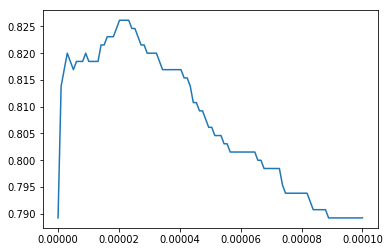

In [1167]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

## Hellinger grid search

In [1168]:
grid = {}

for n in np.linspace(0, 10, 200)[1:]:
    pops = [x[0] for x in classify(poptestdist, dists, p_genre, n = float(n), metric = "hellinger")]
    raps = [x[0] for x in classify(raptestdist, dists, p_genre, n = float(n), metric = "hellinger")]
    predicted = pops + raps
    true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))]
    grid.update({n: confusion_matrix(predicted, true).ravel()})

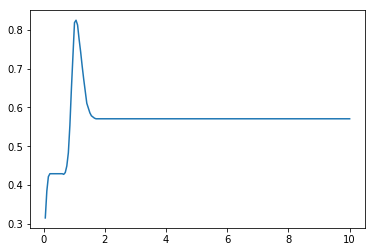

In [1169]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

In [1170]:
grid = {}

for n in np.linspace(0, 10, 200)[1:]:
    pops = [x[0] for x in classify(poptestdist, dists, {"pop": 0.5, "rap": 0.5}, n = float(n), metric = "hellinger")]
    raps = [x[0] for x in classify(raptestdist, dists, {"pop": 0.5, "rap": 0.5}, n = float(n), metric = "hellinger")]
    predicted = pops + raps
    true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))]
    grid.update({n: confusion_matrix(predicted, true).ravel()})

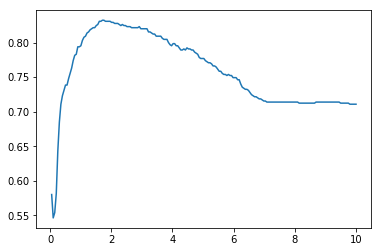

In [1171]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

### Zooming in on the peak

In [1172]:
grid = {}

for n in np.linspace(1.5, 2.5, 100):
    pops = [x[0] for x in classify(poptestdist, dists, {"pop": 0.5, "rap": 0.5}, float(n), metric = "hellinger")]
    raps = [x[0] for x in classify(raptestdist, dists, {"pop": 0.5, "rap": 0.5}, float(n), metric = "hellinger")]
    predicted = pops + raps
    true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))]
    grid.update({n: confusion_matrix(predicted, true).ravel()})

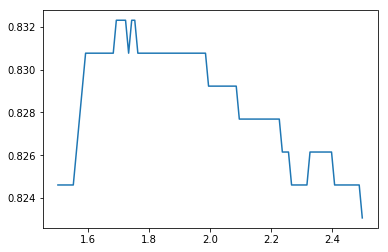

In [1173]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

In [1174]:
pops = [x[0] for x in classify(poptestdist, dists, {"pop": 0.5, "rap": 0.5}, n = 1.7, metric = "hellinger")]
raps = [x[0] for x in classify(raptestdist, dists, {"pop": 0.5, "rap": 0.5}, n = 1.7, metric = "hellinger")]
predicted = pops + raps
true = ["pop" for _ in range(len(pops))] + ["rap" for _ in range(len(raps))]
tn, fp, fn, tp = confusion_matrix(predicted, true).ravel()

### Pop class percentage

In [1176]:
len(pops) / (len(pops) + len(raps))

0.5707692307692308

1. Do a write-up
2. Account for multiple genres within a song
3. dimension reduction



- Account for multiple genres
- Narrow down the dimensions
 - reduce on the most important words
   - gini coefficient
 - reduce w/ linear algebra technique
   - LDA
- try different metrics 
 - KL divergence
- don't want to lean on infrequent words too much

Naive bayes accuracy is NOT 57.21%. Let Bodwin know what you did wrong.

### Accuracy

In [1177]:
(tn + tp) / (tn + fp + fn + tp)

0.8323076923076923

### Precision

In [1178]:
tp / (tp + fp)

0.8458781362007168

### Recall

In [1179]:
tp / (tp + fn)

0.7814569536423841

# Naive Bayes comparison

In [1180]:
def build_vocabulary(df, vocab = {}):
    """
    df: dataframe of tidy data to build vocab
    """
    index = len(vocab)

    for document in df.ID.unique():
        words = df[df.ID == document].word
        for word in words:
            if word not in vocab:
                vocab.update({word: index})
                index += 1
    return vocab


def build_word_vector(vocab, document):
    """
    vocab: dictionary with key = word, value = index of list to populate
    document: document to build a word vector from
    returns: a word vector with 0 = word not present, 1 = word present
    """
    vec = np.zeros(len(vocab))
    words = document.word
    for word in words:
        if word in vocab:
            vec[vocab[word]] += 1
    return vec

In [1181]:
train_words = train[["ID", "word"]]
test_words = test[["ID", "word"]]

vocab = build_vocabulary(train_words)
vocab = build_vocabulary(test_words, vocab)

In [1182]:
X_train, y_train, X_test, y_test = [], [], [], []

poptrain = train[train["Pop"] == 1]
raptrain = train[train["Rap"] == 1]

poptest = test[test["Pop"] == 1]
raptest = test[test["Rap"] == 1]

# build training set

for doc in poptrain.ID.unique():
    tmp = poptrain[poptrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("pop")
    
for doc in raptrain.ID.unique():
    tmp = raptrain[raptrain.ID == doc]
    X_train.append(build_word_vector(vocab, tmp))
    y_train.append("rap")  
    
# build testing set
    
for doc in poptest.ID.unique():
    tmp = poptest[poptest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("pop")
    
for doc in raptest.ID.unique():
    tmp = raptest[raptest.ID == doc]
    X_test.append(build_word_vector(vocab, tmp))
    y_test.append("rap")

In [ ]:
grid = {}

for n in np.linspace(0, 0.01, 100)[1:]:
    clf = BernoulliNB(alpha = n)
    clf.fit(X_train, y_train)
    grid.update({n: confusion_matrix(clf.predict(X_test), y_test).ravel()})

In [ ]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

In [ ]:
clf = BernoulliNB(alpha = 0.00001)
clf.fit(X_train, y_train)

In [ ]:
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()

In [ ]:
confusion_matrix(clf.predict(X_test), y_test)

In [ ]:
(tn + tp) / (tn + fp + fn + tp)

In [ ]:
tp / (tp + fp)

In [ ]:
tp / (tp + fn)

In [ ]:
grid = {}

for n in np.linspace(0, 1, 100)[1:]:
    clf = MultinomialNB(alpha = n)
    clf.fit(X_train, y_train)
    grid.update({n: confusion_matrix(clf.predict(X_test), y_test).ravel()})

In [ ]:
plt.plot([i for i in grid], [(grid[i][0] + grid[i][-1]) / sum(grid[i]) for i in grid])

In [ ]:
clf = MultinomialNB(alpha = 0.6)
clf.fit(X_train, y_train)

In [ ]:
tn, fp, fn, tp = confusion_matrix(clf.predict(X_test), y_test).ravel()

In [ ]:
confusion_matrix(clf.predict(X_test), y_test)

In [ ]:
(tn + tp) / (tn + fp + fn + tp)

In [ ]:
tp / (tp + fp)

In [ ]:
tp / (tp + fn)